# Fractal Pillars and Zebras

In [this post](https://www.reddit.com/r/Python/comments/e4js7g/an_error_in_my_code_makes_the_mandelbrot_set_look/?utm_medium=android_app&utm_source=share), Reddit user `u/FlyingCow313` shows an image that resulted from thier attempt to implement a Mandlebrot renderer. 

<img src="https://preview.redd.it/y9qbirw5w1241.png?width=960&crop=smart&auto=webp&s=a3221afb618952aeee50371b7d33abe3db852dcc" width="500px"/>

In this notebook we are going to recreate the pattern and investigate how it is generated.

First, lets create a working Mandlebrot renderer, then we will try to mess with it to recreate the effect.

Note: I have adapted basic generation and rendering code from [this](https://tomroelandts.com/articles/how-to-compute-colorful-fractals-using-numpy-and-matplotlib) and [this](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [431]:
def create_mandlebrot(
    n = 700, # screen size pixels

    s = 1,  # Scale.
    p = 0.6 + 0j, # screen offset
    
    horizon = 2.0 ** 20,
    iterations=500
):
    
    s = int(s * n * 4 / 7) # maps scale factor to pixel space
    x = np.linspace(-n / s, n / s, num=n).reshape((1, n))
    y = np.linspace(-n / s, n / s, num=n).reshape((n, 1))
    
    Z = np.tile(x, (n, 1)) + 1j * np.tile(y, (1, n)) - p
    C = Z.copy()
    
    M = np.full((n, n), True, dtype=bool)
    N = np.zeros((n, n))
    
    log_horizon = np.log(np.log(horizon))/np.log(2)
    
    for i in range(iterations):
        Z[M] = Z[M] * Z[M] + C[M]
        M[np.abs(Z) > horizon] = False
        N[M] = i - np.log(np.log(np.abs(Z[M]) + 1))/np.log(2) + log_horizon
        
    return N

In [432]:
N = create_mandlebrot(n=2000, iterations=2000)

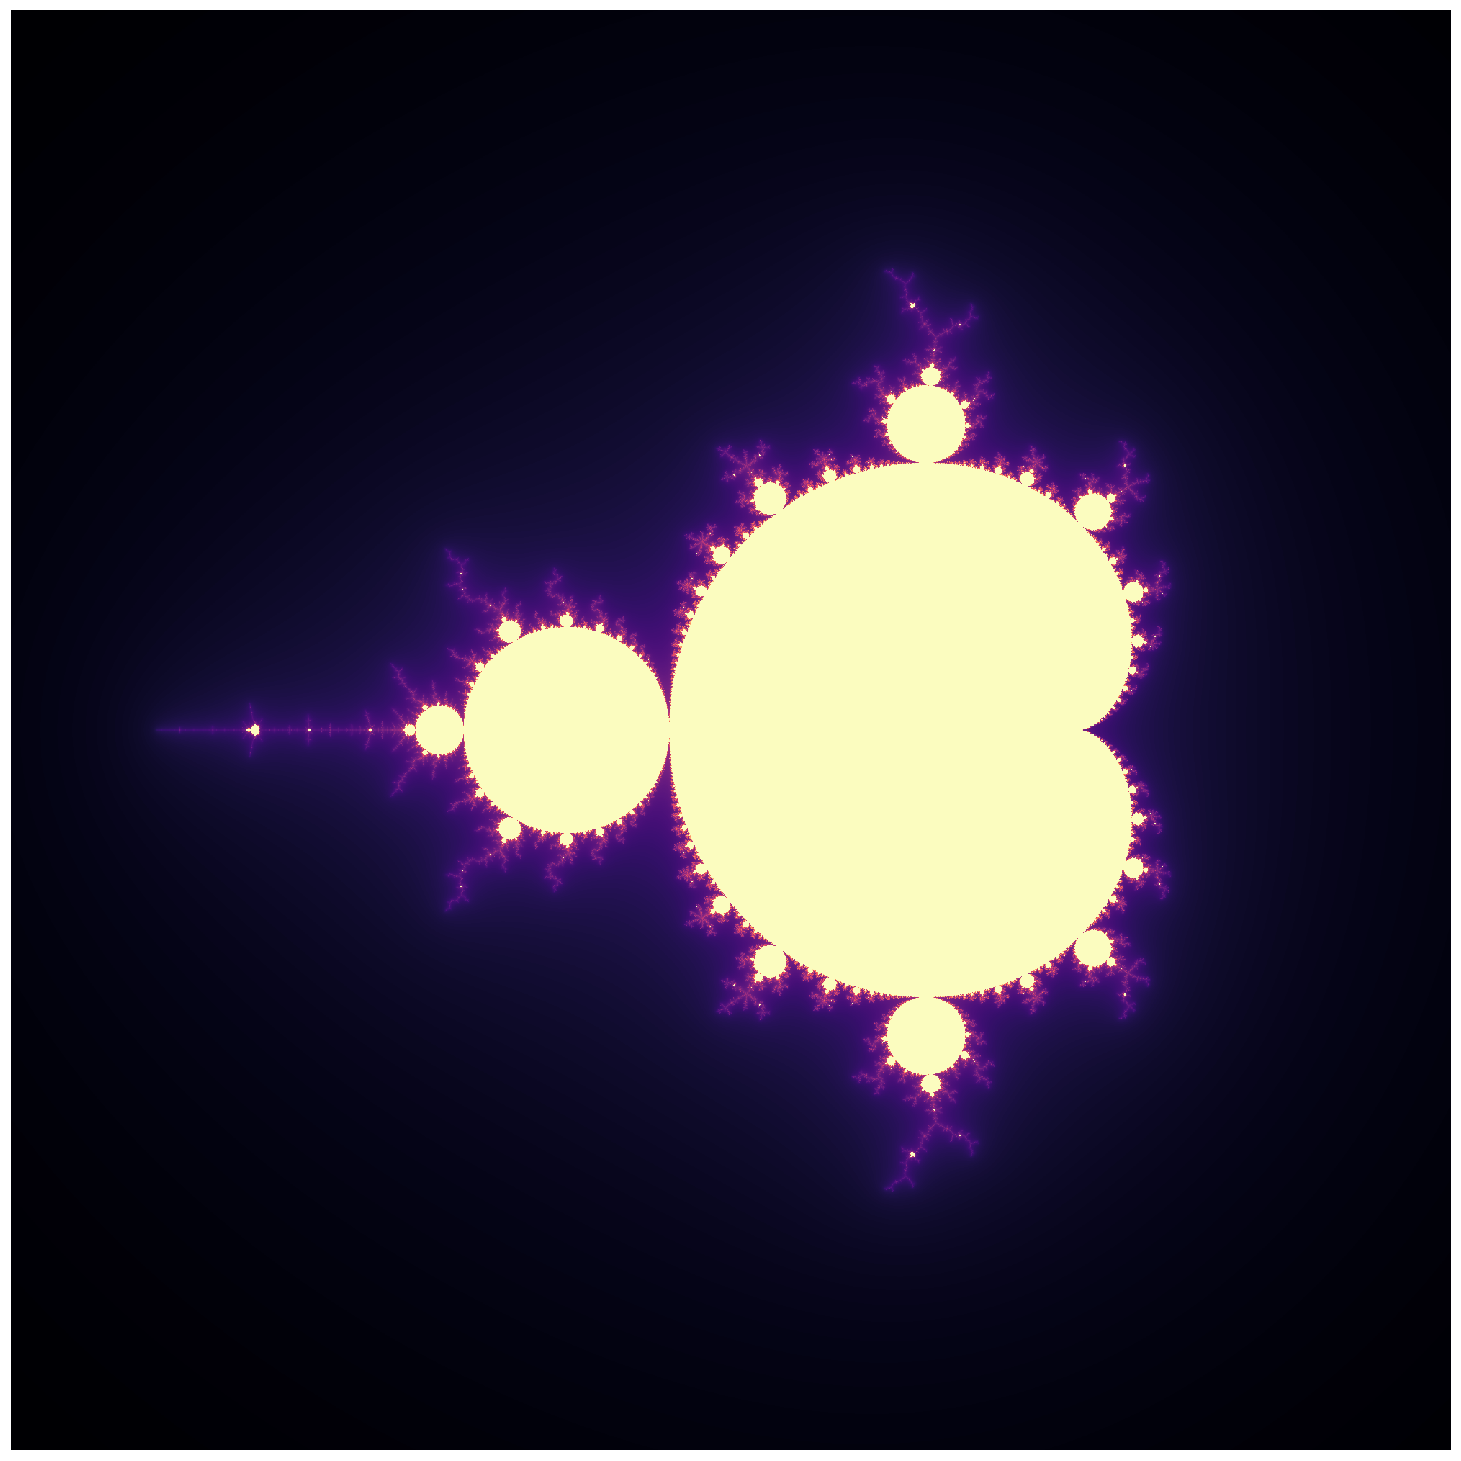

In [433]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(np.flipud(np.log(1 + N)), cmap='magma');

## Recreating the Effect

The key error is in the following code snippet (from [this file](https://github.com/TFC-343/Mandelbrot/blob/master/main.py)):
```
    while comparative(z, '2500+2500i', '<') > 1 and comparative(z, '-2500-2500i', '>') > 1 and loops < 500:
        z = comp(comp(str(z), str(z), 'times'), str(r/100)+'+'+str(f/100)+'i', 'add')
        loops += 1
    if comparative(z, '1000+1000i', '<') > 1:
        return 'black'
    else:
        return 'white'
```
The `comparative` function takes two strings representing complex numbers and a third representing the comparative operator. Internally, for complex arguments `a + bi` and `x + iy`, and comparative operator `op`, it returns true if and only if `(a op b) and (b op y)`. Therefore the condition `comparative(z, '2500+2500i', '<')` is only true if the imaginary and real components of `z` are less than `2500`.

In normal Mandelbrot rendering our terminal condition is based upon the magnitude of `z`, whereas in this situation the iteration stops when `z` enters into one of the two boxes  $[(2500, 2500), (\infty, \infty)]$ or $[(-2500, -2500), (-\infty, -\infty)]$.

In [397]:
def create_mandlebrot_pillars(
    n = 700, # screen size pixels

    s = 1,  # Scale.
    p = 0.6 + 0j, # screen offset
    
    iterations=500
):

    s *= n * 4 / 7 # maps scale factor to pixel space
    x = np.linspace(-n / s, n / s, num=n).reshape((1, n))
    y = np.linspace(-n / s, n / s, num=n).reshape((n, 1))
    Z = np.tile(x, (n, 1)) + 1j * np.tile(y, (1, n)) - p

    C = Z.copy()
    M = np.full((n, n), False, dtype=bool)
    N = np.zeros((n, n))
    
    for i in range(iterations):
        Z[M] = Z[M] * Z[M] + C[M]
        M = (
            ((Z.imag < 2500) & (Z.real < 2500)) & 
            ((Z.imag > -2500) & (Z.real > -2500))
        )
    
    M = (Z.imag < 1000) & (Z.real < 1000)
    return ~M

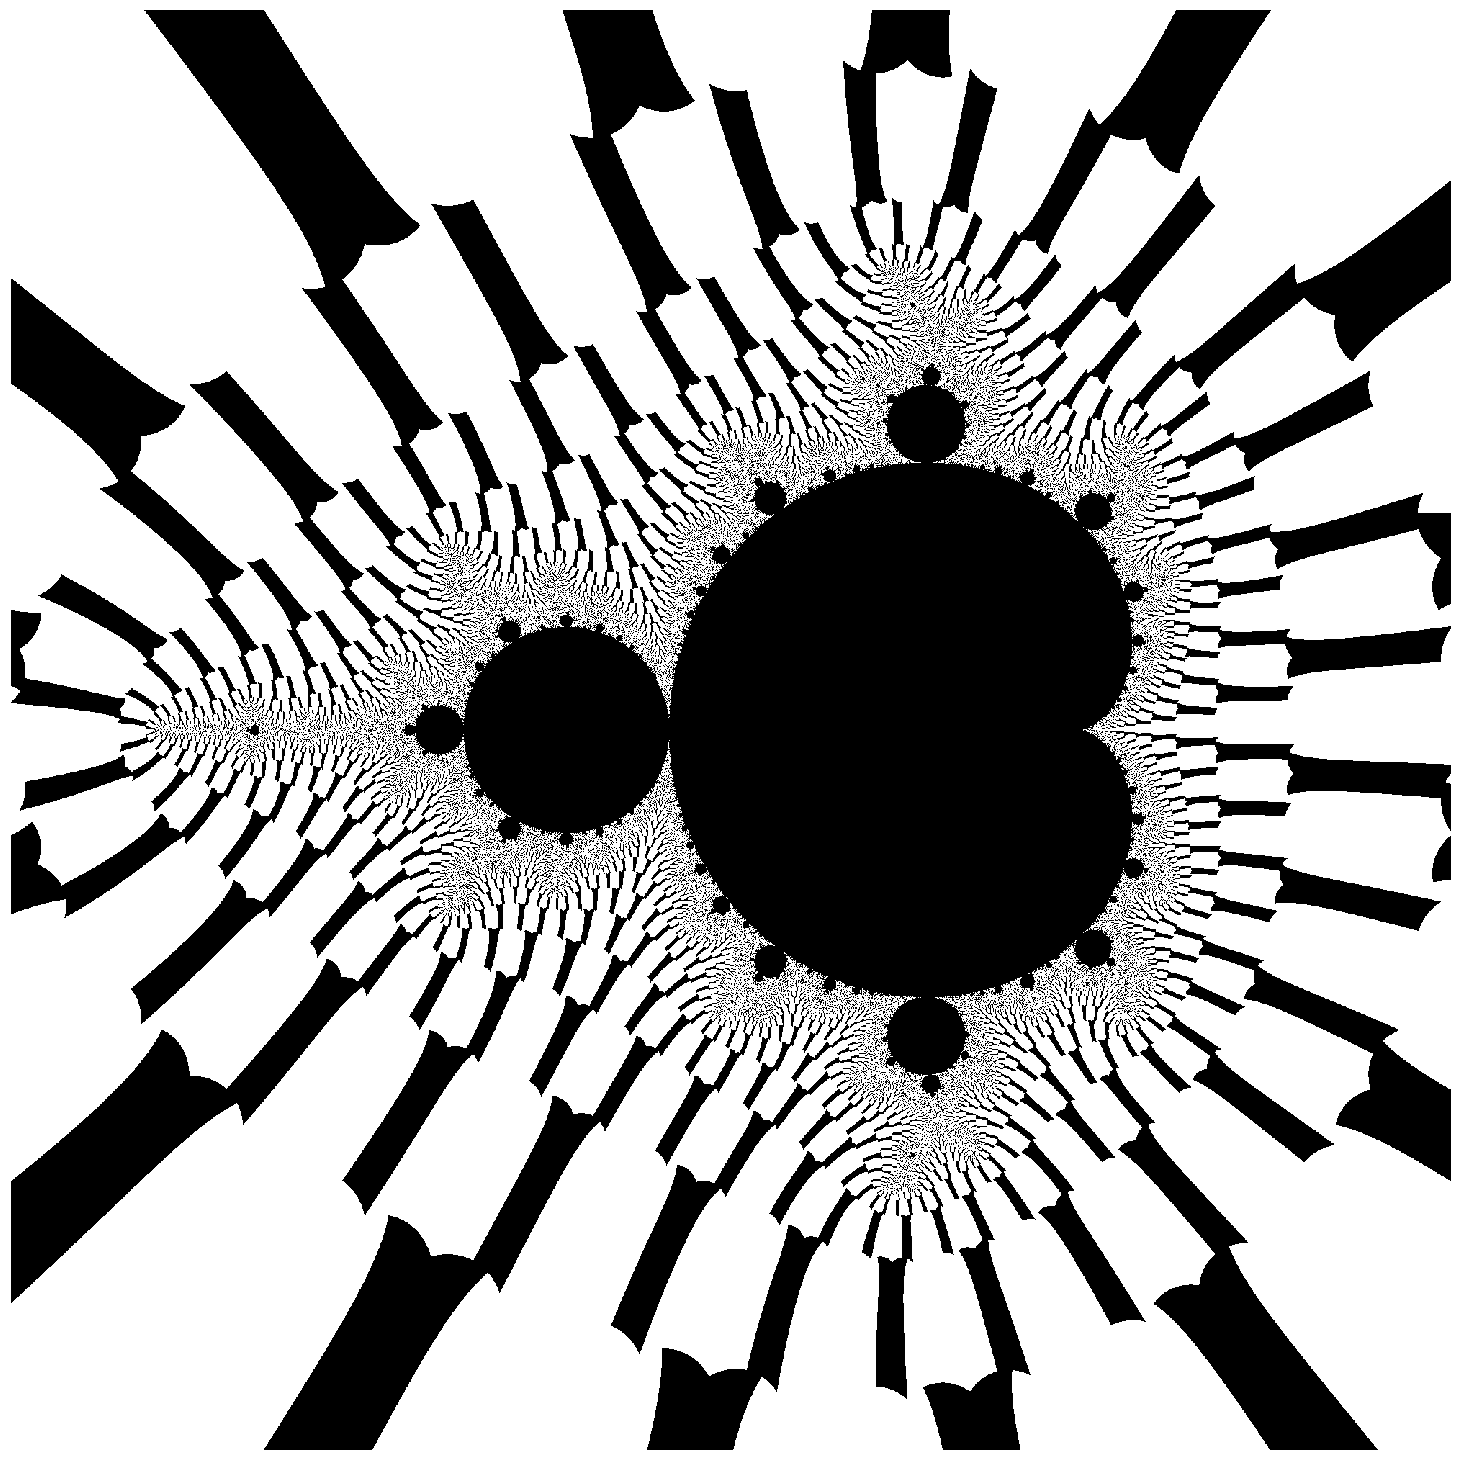

In [400]:
N = create_mandlebrot_pillars(iterations=500, n=2000)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
ax.set_xticks([]); ax.set_yticks([])
plt.imshow(np.flipud(N), cmap='gray');

In [401]:
def create_mandlebrot_zebra(
    n = 700, # screen size pixels

    s = 1,  # Scale.
    p = 0.6 + 0j, # screen offset
    
    iterations=500
):
    
    s *= n * 4 / 7 # maps scale factor to pixel space
    x = np.linspace(-n / s, n / s, num=n).reshape((1, n))
    y = np.linspace(-n / s, n / s, num=n).reshape((n, 1))
    Z = np.tile(x, (n, 1)) + 1j * np.tile(y, (1, n)) - p

    C = Z.copy()
    M = np.full((n, n), False, dtype=bool)
    N = np.zeros((n, n))
    
    for i in range(iterations):
        Z[~M] = Z[~M] * Z[~M] + C[~M]
        M = (
            ((Z.imag > 2500) & (Z.real > 2500)) | 
            ((Z.imag < -2500) & (Z.real < -2500))
        )
    
    M = (Z.imag < 1000) & (Z.real < 1000)
    return M

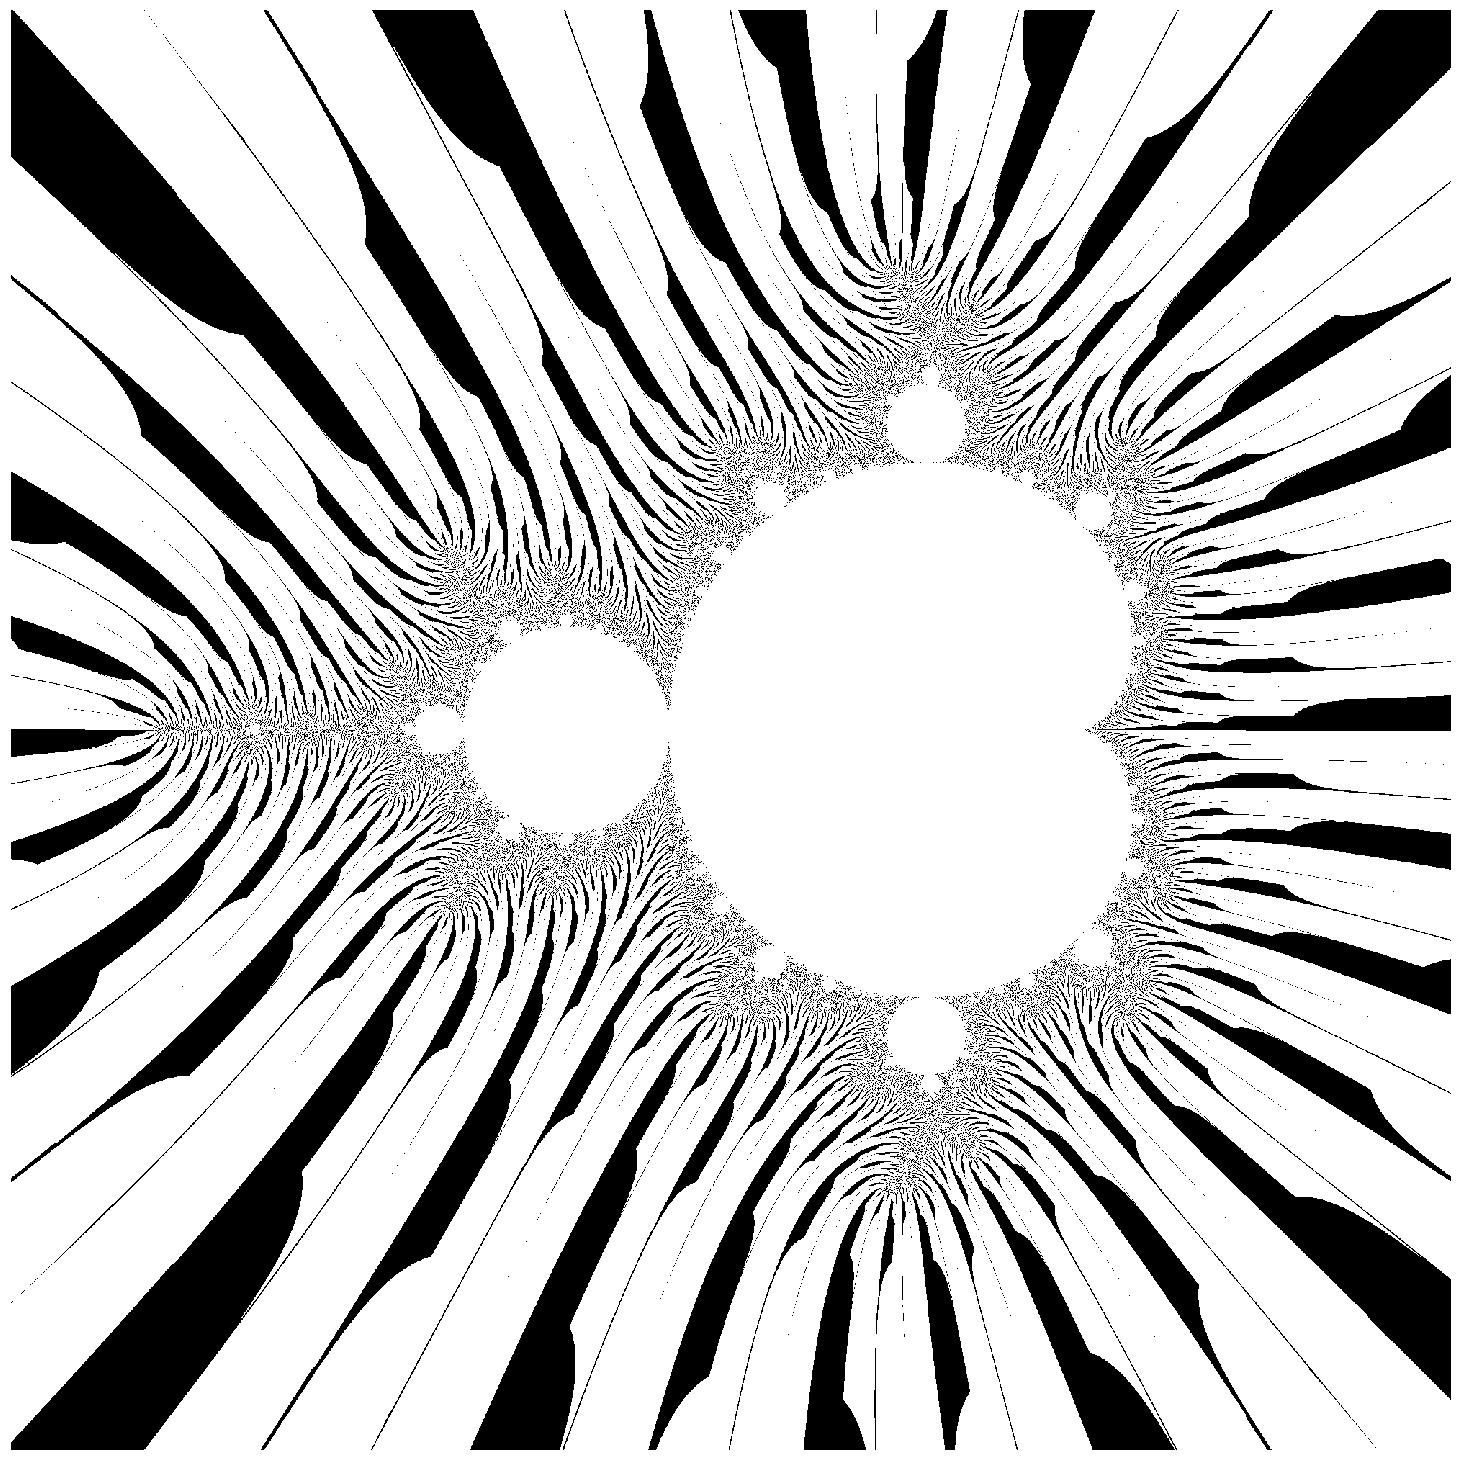

In [403]:
N = create_mandlebrot_zebra(iterations=500, n=2000)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
ax.set_xticks([]); ax.set_yticks([])
plt.imshow(np.flipud(N), cmap='gray');

In [375]:
def create_mandlebrot_with_angles(
    n = 700, # screen size pixels

    s = 1,  # Scale.
    p = 0.6 + 0j, # screen offset
    
    horizon = 2.0 ** 10,
    iterations=500
):
    
    s = int(s * n * 4 / 7) # maps scale factor to pixel space
    x = np.linspace(-n / s, n / s, num=n).reshape((1, n))
    y = np.linspace(-n / s, n / s, num=n).reshape((n, 1))
    
    Z = np.tile(x, (n, 1)) + 1j * np.tile(y, (1, n)) - p
    C = Z.copy()
    
    M = np.full((n, n), True, dtype=bool)
    N = np.zeros((n, n))
    
    for i in range(iterations):
        Z[M] = Z[M] * Z[M] + C[M]
        M[np.abs(Z) > horizon] = False
        N[M] = np.angle(Z[M]) + np.pi
        
    return N

In [384]:
N = create_mandlebrot_with_angles(n=2000)

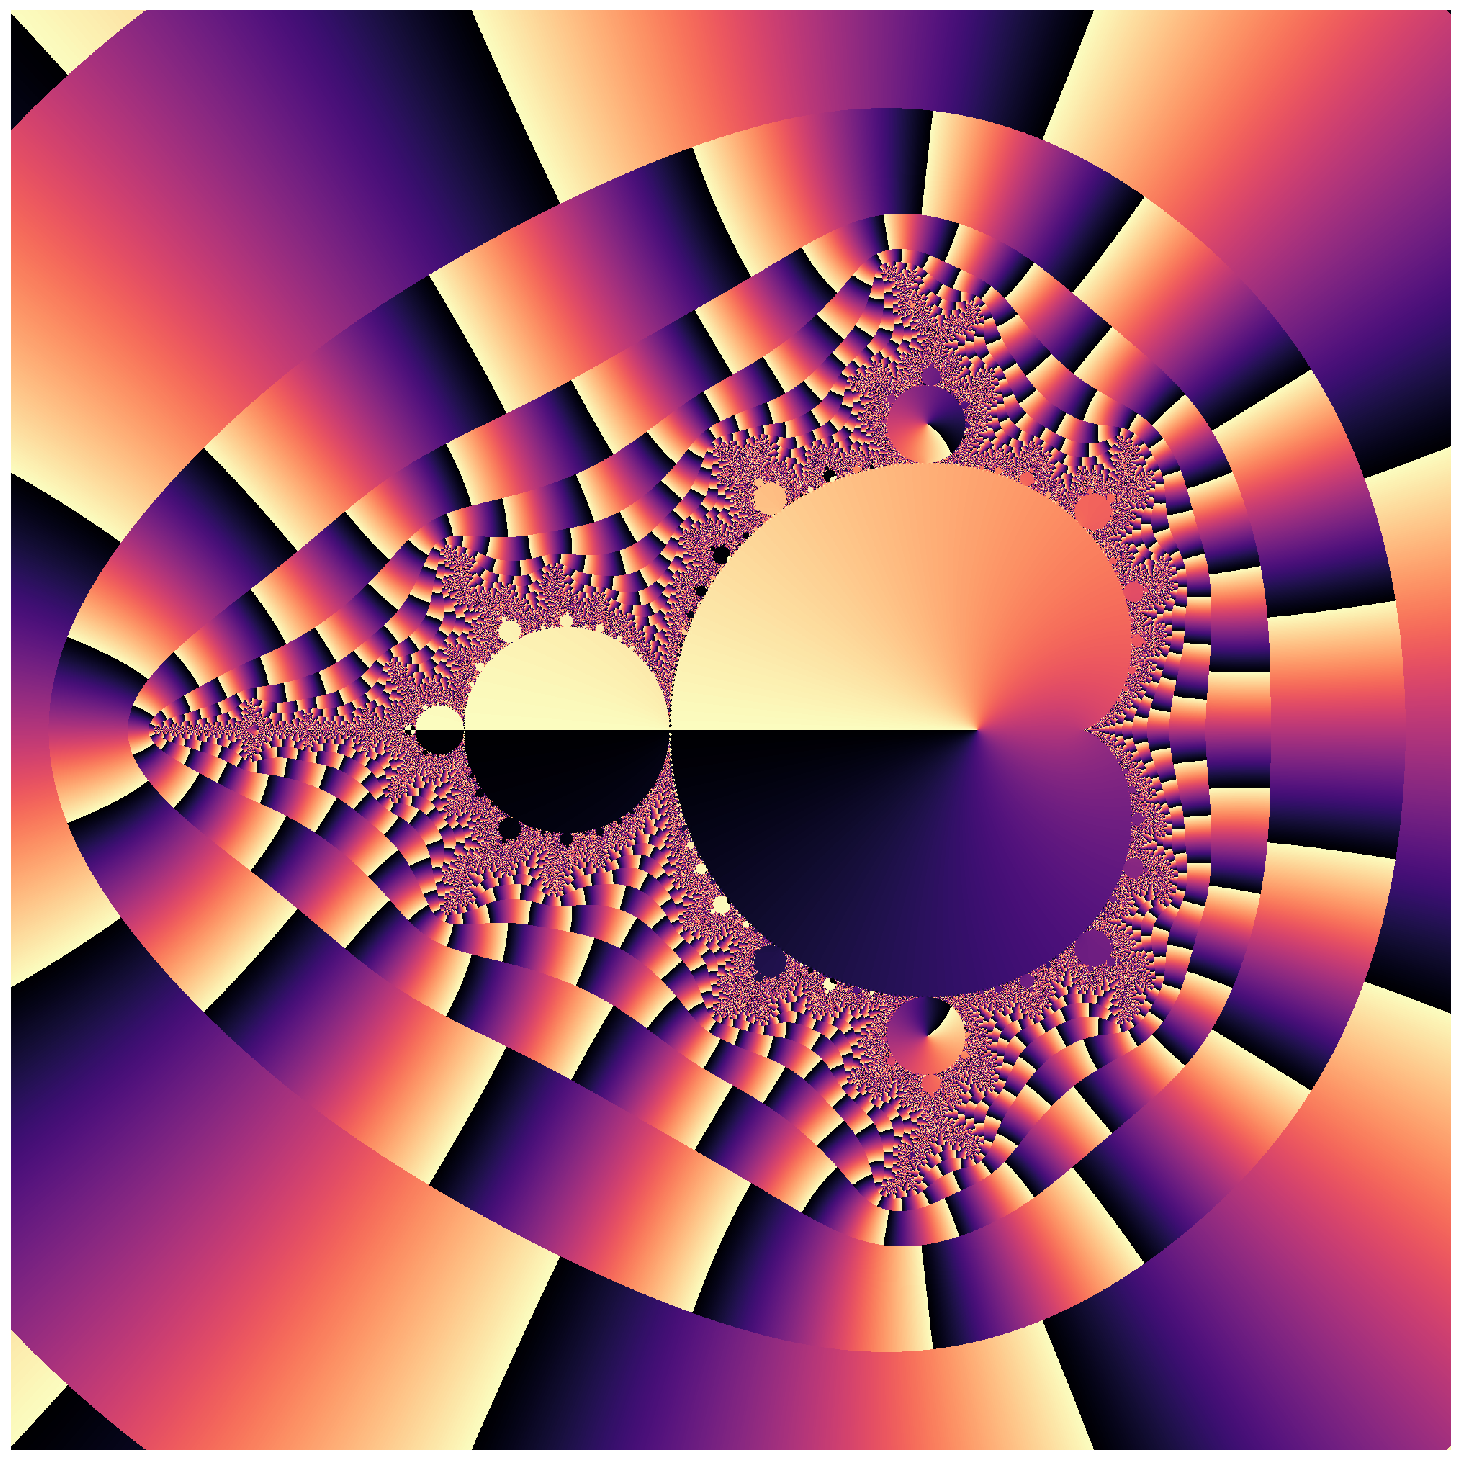

In [385]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
ax.set_xticks([]); ax.set_yticks([])
plt.imshow(np.flipud(N), cmap='magma');

In [386]:
N = create_mandlebrot_with_angles(n=2000, horizon=2, iterations=50)

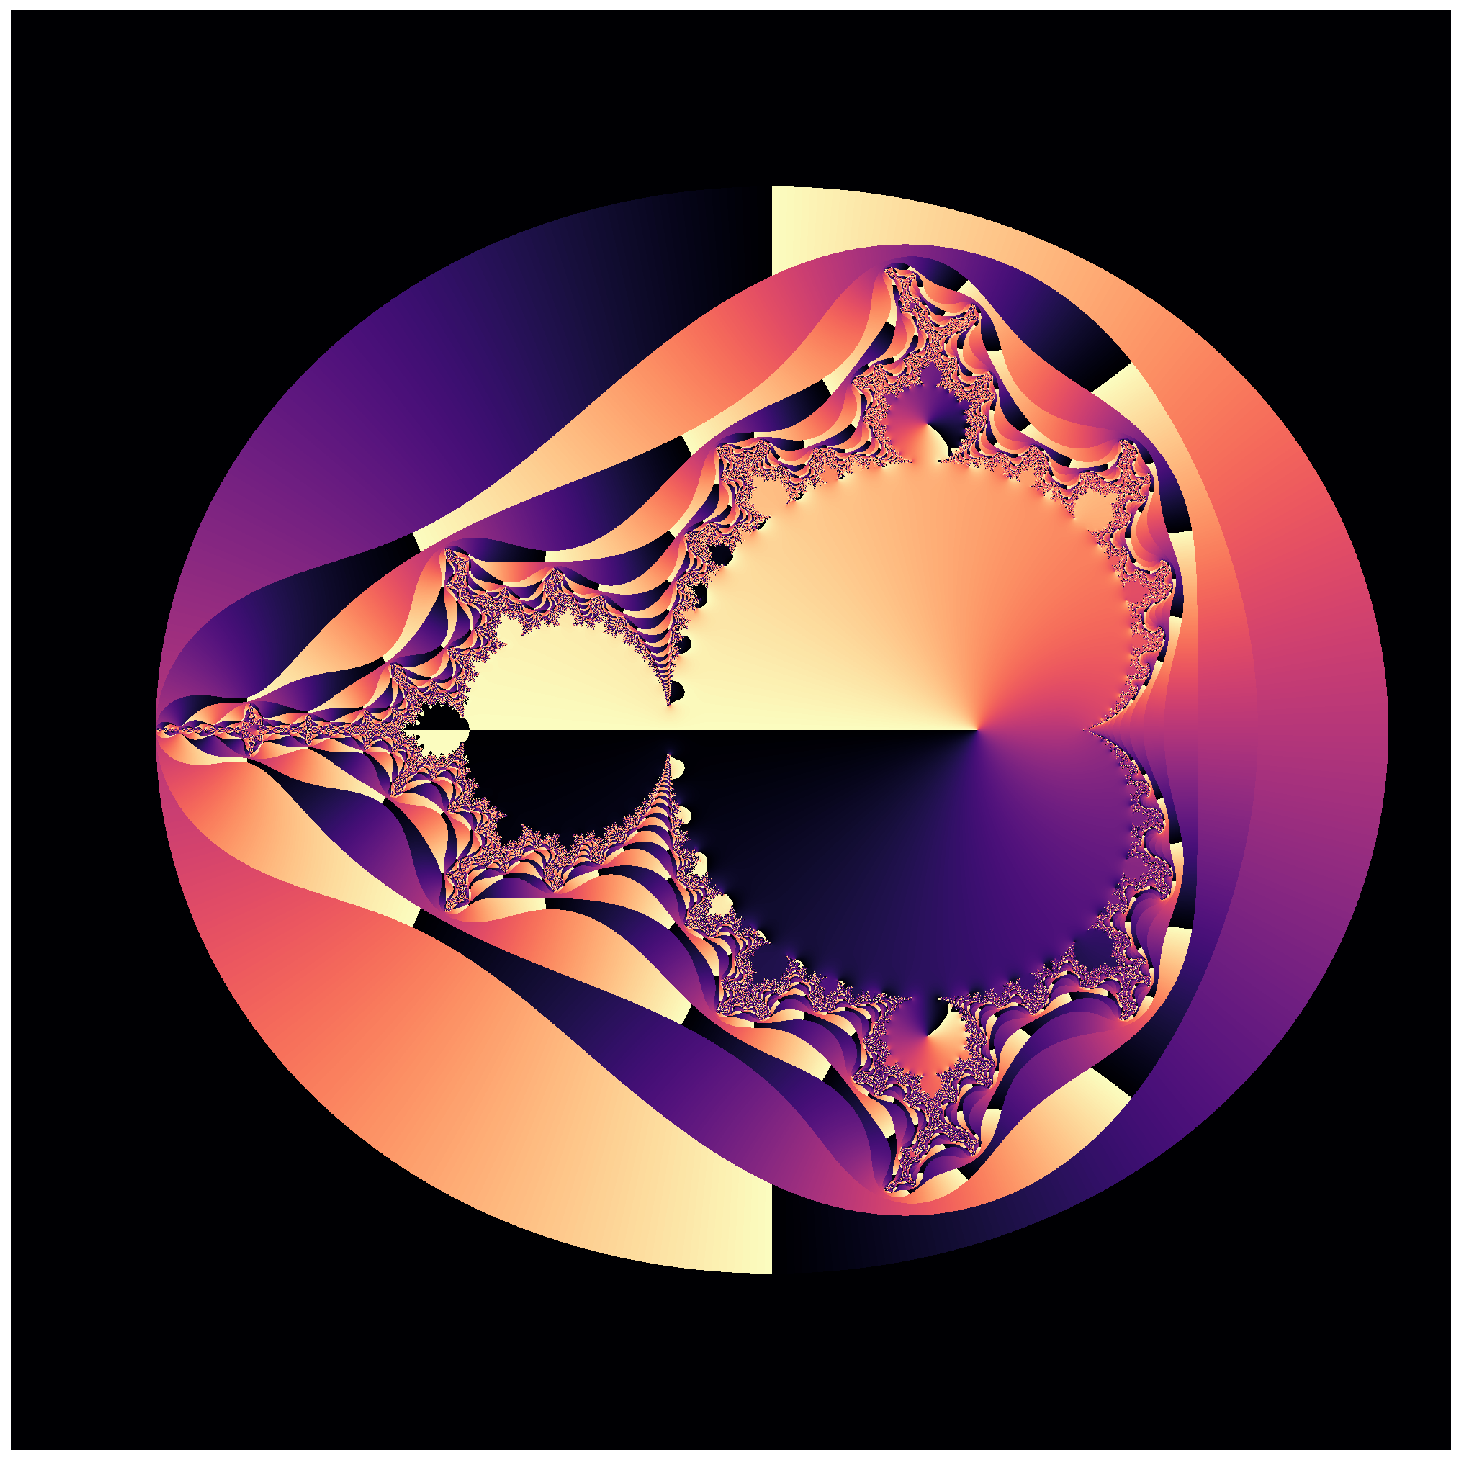

In [387]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
ax.set_xticks([]); ax.set_yticks([])
plt.imshow(np.flipud(N), cmap='magma');

In [429]:
N = create_mandlebrot_with_angles(n=2000, horizon=2, iterations=2000, s=2.5, p=1+0j)

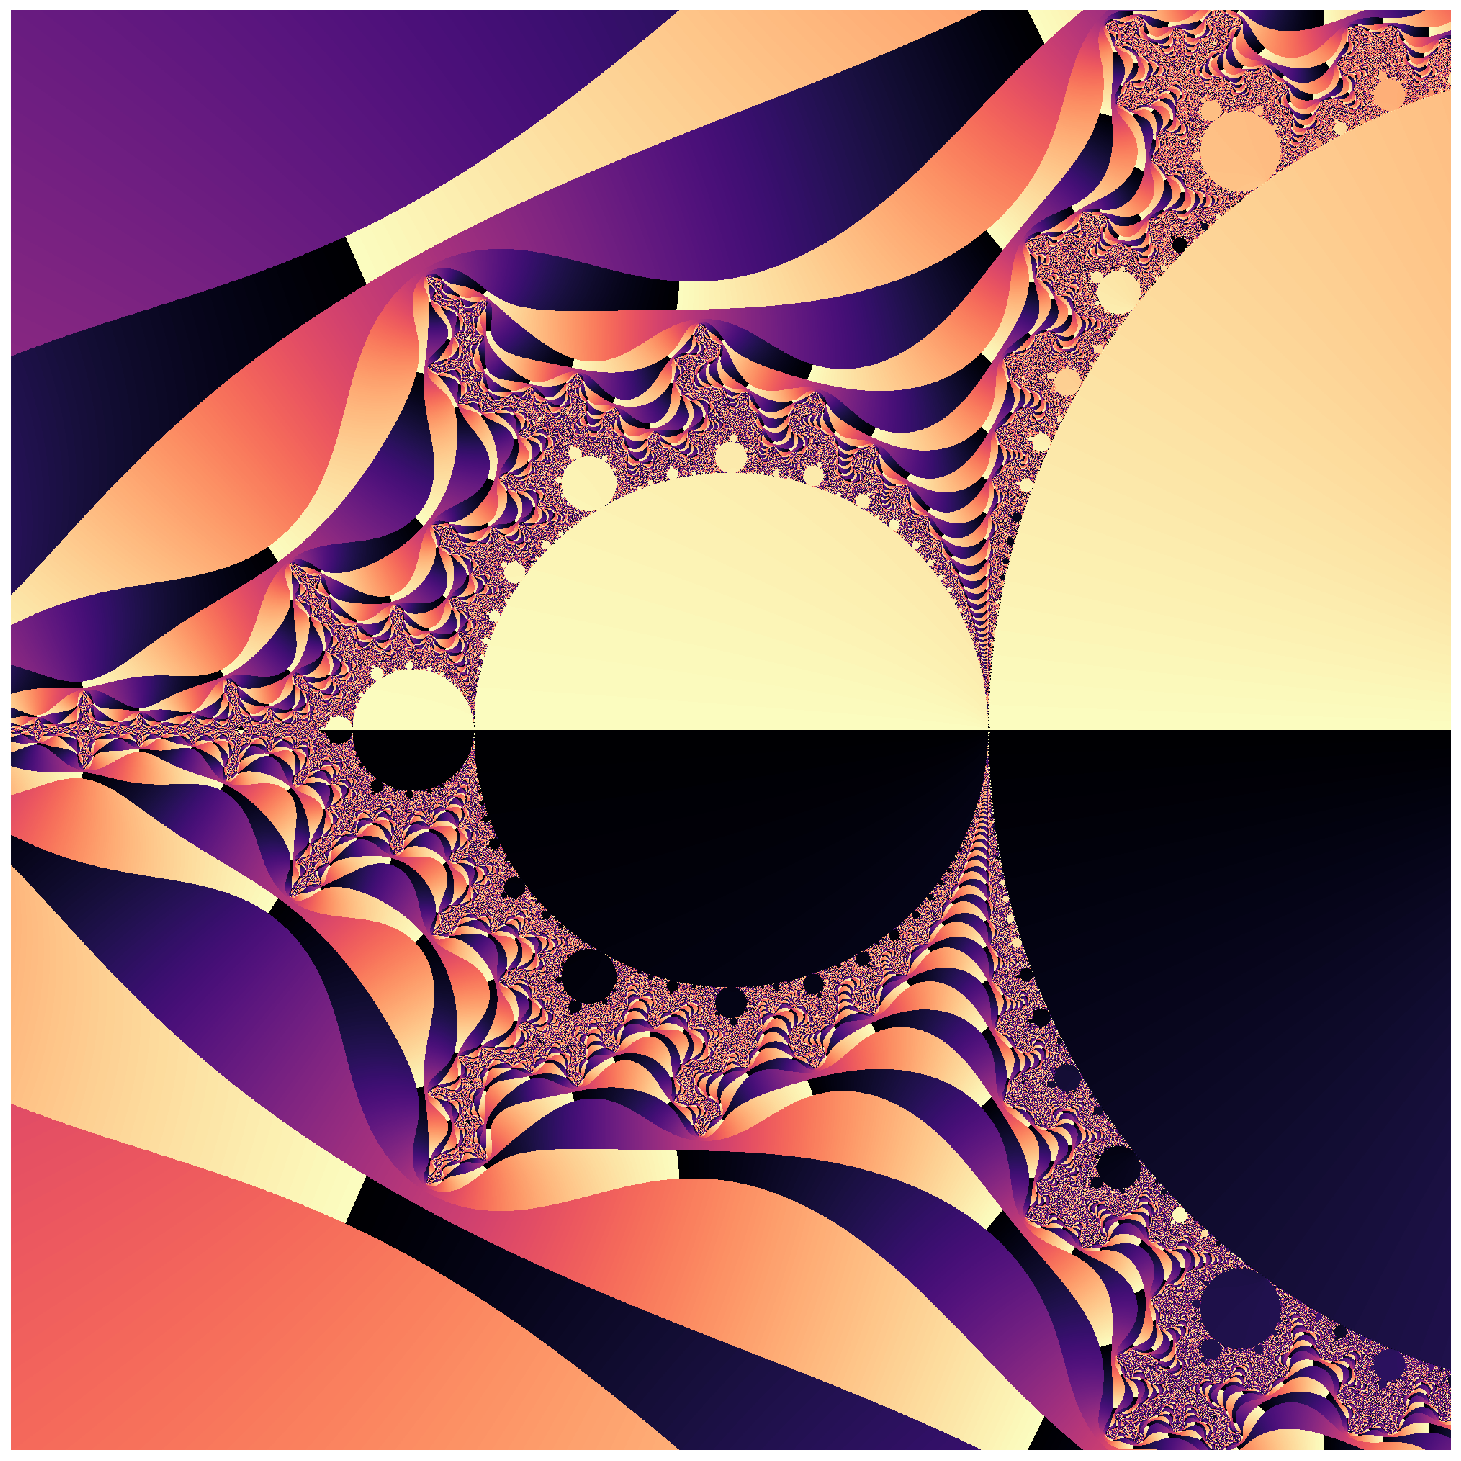

In [430]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
ax.set_xticks([]); ax.set_yticks([])
plt.imshow(np.flipud(N), cmap='magma');